# Part 3: combining results from RNA-seq and ChIP-seq analyses

In this notebook we combine the results from parts 1 and 2 by finding ChIP-seq peaks that have differentially expressed genes nearby. Fill in the parts with ### and include the filled template as part of your submission.

Set the working directory 

In [5]:
setwd("/coursedata/users/leey17/part_3")

We will be using **GenomicRanges** package, so first let's import it

In [6]:
library("GenomicRanges")

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

Load file containing chromatin lengths

In [7]:
human.chromlens <- readRDS("/coursedata/project/human.chromlens.RDS")

Define the ChIP-seq peak file name and its path and load the file into the workspace

In [8]:
ChIP_seq_results_filename="/coursedata/users/leey17/part_2/NR3C1_0hour_vs_1hour_c3.0_cond2.bed"
peak_file_0based <-read.table(ChIP_seq_results_filename, skip=1, stringsAsFactors = FALSE)#first row of the file is skipped as it is not a peak

Pick the first three columns from the peak file and name them 

In [9]:
peak_file_1based <- peak_file_0based[c(1,2,3)]
colnames(peak_file_1based)<-c("chrom","start","end")

In BED files the coordinate indexing starts from 0. In this analysis we need 1-based indexing so we add 1 to coordinate columns.

In [10]:
peak_file_1based[2]<- peak_file_1based[2]+1
peak_file_1based[3]<- peak_file_1based[3]+1

Make a Granges object of the peak file object

In [11]:
peak_GRanges<-as(peak_file_1based,"GRanges")

Define the edgeR results file name and its path and load the file into the workspace

In [12]:
edgeR_results_filename="/coursedata/users/leey17/result_part1.txt"

edgeR_table <-read.table(edgeR_results_filename, header=TRUE, stringsAsFactors = FALSE)

Make a data frame containing the edgeR results

In [13]:
df<-data.frame(chrom=edgeR_table$Chromosome,
               start=edgeR_table$Gene_Start_Base,
               end=edgeR_table$Gene_End_Base,
               strand=edgeR_table$Strand,
               Ensembl_Gene_IDs=edgeR_table$Ensembl_Gene_IDs,
               logFC=edgeR_table$logFC,
                logCPM=edgeR_table$logCPM,
               LR=edgeR_table$LR,
               PValue=edgeR_table$PValue,
               FDR=edgeR_table$FDR, 
                Attribute=edgeR_table$Attribute,
               Gene_Names=edgeR_table$Gene_Symbols)

Pick genes with FDR<=0.05, i.e. the differentially expressed ones, from the data frame object

In [14]:
df$FDR <- as.numeric(as.character(df$FDR))


In [15]:
df_filtered <- df[df$FDR<=0.05,]

Make a GRanges object out of the data frame

In [16]:
diff_exp_genes <- makeGRangesFromDataFrame(df_filtered, keep.extra.columns=TRUE, seqinfo=Seqinfo(seqnames=names(human.chromlens),
                      seqlengths=human.chromlens,
                      isCircular=c( rep(FALSE, length(human.chromlens)-1), TRUE ),
                      genome="hgs38"))

Resize the genomic ranges intervals to length 1, use start coordinate as an anchor to each element.

In [17]:
diff_exp_genes_TSS=resize(diff_exp_genes,1, fix="start")

Calculate the distance between the peak and the nearest gene

In [18]:
tmp=distanceToNearest(peak_GRanges,diff_exp_genes_TSS, ignore.strand=TRUE)

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr22_KI270731v1_random, chr22_KI270734v1_random, chrUn_GL000195v1, chrUn_KI270333v1, chrUn_KI270336v1, chrUn_KI270337v1, chrUn_KI270466v1, chrUn_KI270467v1
  - in 'y': chrM
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


Plot a histogram of the distances between peaks and genes just to see how the results look like

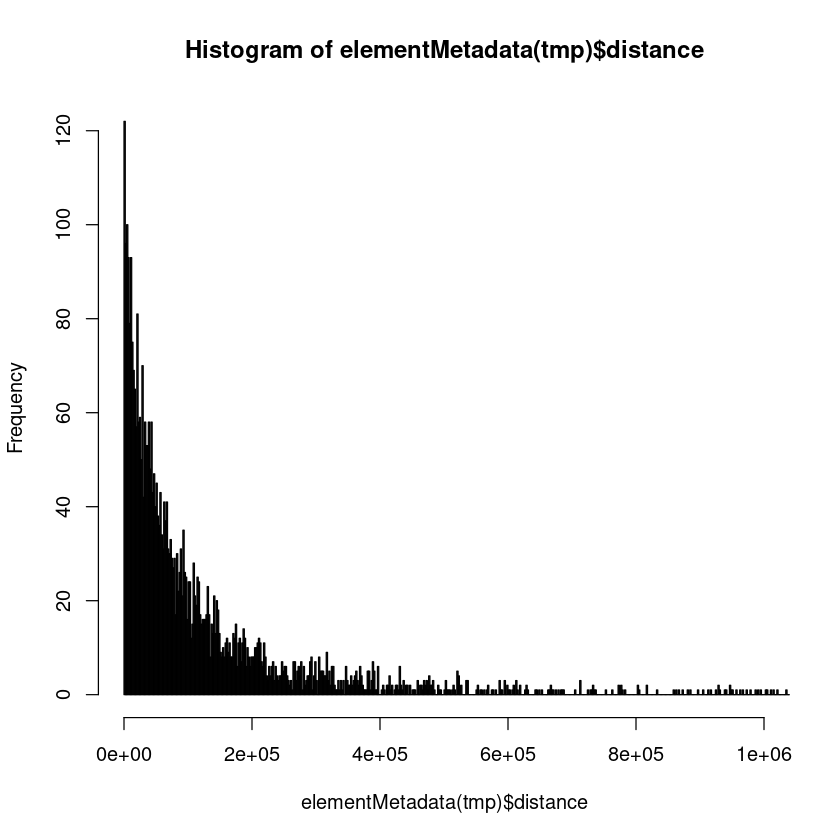

In [19]:
hist(elementMetadata(tmp)$distance, breaks=3000, xlim=c(0,1000000)) 

Find peaks with DE genes nearby, the maximum distance between the peak and gene is 100000 basepairs

In [20]:
max_dist=100000
peaks_with_DE_genes_nearby<-peak_GRanges[queryHits(tmp)]

Define the file name and path where the results are stored

In [22]:
output_filename="/coursedata/users/leey17/part_3/overlap_results.bed"

Save results

In [23]:
write.table(as.data.frame(peaks_with_DE_genes_nearby),file = output_filename, sep="\t", quote = FALSE,row.names = FALSE,col.names=FALSE)